In [1]:
import numpy as np
from jesse.helpers import timestamp_to_time

candles = np.load("data/btc_1m.npy")
print(timestamp_to_time(candles[0, 0]))
candles.shape

2024-01-01T00:00:00+00:00


(807840, 6)

In [2]:
import pandas as pd
from jesse.utils import numpy_candles_to_dataframe
from joblib import Parallel, delayed

from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret_from_candles

# label and features
candles = candles[candles[:, 5] > 0]

df = numpy_candles_to_dataframe(candles)

feature_and_label = []

# label
label = np.log(df["close"].shift(-1) / df["close"]).fillna(0)
label.name = "label"
feature_and_label.append(label)

# high low range
hl_range = np.log(df["high"] / df["low"])
hl_range.name = "hl_range"
feature_and_label.append(hl_range)

# price position
price_pos = (df["close"] - df["low"]) / (df["high"] - df["low"] + 1e-10)
price_pos.name = "price_position"
feature_and_label.append(price_pos)

RANGE = [30, 60, 120]

# log return
for i in RANGE:
    series = np.log(df["close"] / df["close"].shift(i))
    series.name = f"r{i}"
    feature_and_label.append(series)

# volume features
for i in RANGE:
    vol_series = np.log(df["volume"] / df["volume"].shift(i))
    vol_series.name = f"vol{i}"
    feature_and_label.append(vol_series)

# sample entropy
for i in RANGE:
    log_ret_list = log_ret_from_candles(candles, [i] * len(candles))
    entropy_array = Parallel(n_jobs=-1)(
        delayed(sample_entropy_numba)(i) for i in log_ret_list
    )
    len_gap = len(df) - len(entropy_array)

    entropy_array = [np.nan] * len_gap + entropy_array
    entropy_series = pd.Series(entropy_array, index=df.index)
    entropy_series.name = f"r{i}_en"

df_features_and_label = pd.concat(feature_and_label, axis=1)

NA_MAX_NUM = df_features_and_label.isna().sum().max()
df_features_and_label = df_features_and_label.iloc[NA_MAX_NUM:]

cols = [col for col in df_features_and_label.columns if col != "label"]
X = df_features_and_label[cols].values.astype(np.float32)

In [3]:
from bar_research.symbolic_regression_deap_advanced import (
    AdvancedSymbolicRegressionDEAP,
)

sr_model = AdvancedSymbolicRegressionDEAP(
    population_size=3000,
    generations=50,
    tournament_size=7,
    crossover_prob=0.9,
    mutation_prob=0.1,
    max_depth=17,
    init_depth=(2, 8),
    elite_size=25,
    n_islands=10,
    migration_rate=0.1,
    local_search_prob=0.1,
    adaptive_mutation=True,
    n_jobs=-1,
    # random_state=42,
)

sr_model.fit(X, cols, NA_MAX_NUM)

开始多目标符号回归进化...
种群大小: 3000, 进化代数: 50
岛屿数量: 10, 迁移率: 0.1
使用多进程加速: 10 个进程
Generation 0/50 completed
Generation 20/50 completed
Generation 40/50 completed

进化完成! Pareto前沿大小: 2998
最佳峰度偏差: 3.114002
对应复杂度: 18


In [4]:
num_indiv = 0
for lst in sr_model.best_individuals:
    num_indiv += len(lst)
num_indiv

194

In [5]:
for i in sr_model.get_best_expressions(20):
    print(i)

{'rank': 1, 'expression': 'min(max(min(sub(vol60, hl_range), price_position), zero), abs(r60))', 'kurtosis_deviation': 3.1140023818105447, 'complexity': 18.0, 'height': 4, 'size': 10, 'num_bars': 6589, 'actual_kurtosis': 3.114002381810546, 'skewness': -0.06729181432524937, 'sharpe_ratio': 0.04520498181549767}
{'rank': 2, 'expression': 'min(max(min(vol120, price_position), zero), abs(r60))', 'kurtosis_deviation': 3.167391846379648, 'complexity': 14.0, 'height': 3, 'size': 8, 'num_bars': 6586, 'actual_kurtosis': 3.1673918463796484, 'skewness': -0.05913207280758007, 'sharpe_ratio': 0.04540908502850925}
{'rank': 3, 'expression': 'min(max(min(vol120, price_position), zero), abs(r60))', 'kurtosis_deviation': 3.167391846379648, 'complexity': 14.0, 'height': 3, 'size': 8, 'num_bars': 6586, 'actual_kurtosis': 3.1673918463796484, 'skewness': -0.05913207280758007, 'sharpe_ratio': 0.04540908502850925}
{'rank': 4, 'expression': 'min(max(min(vol120, price_position), zero), abs(r60))', 'kurtosis_devi

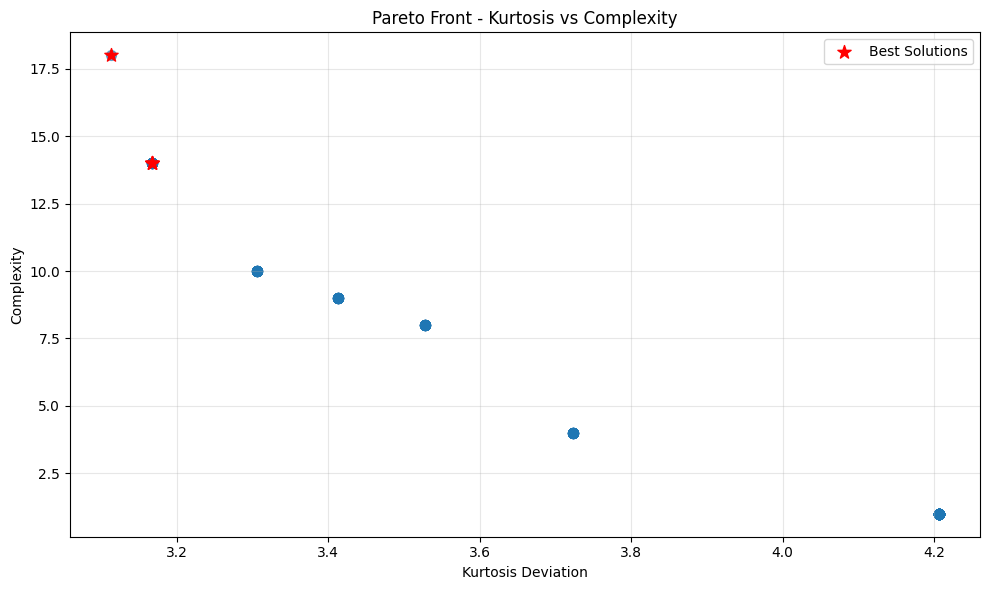

In [6]:
sr_model.visualize_pareto_front()